In [ ]:
import os
import torch
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn

from torchinfo import summary
from tqdm import tqdm

import json
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')

# Planet : Amazon space -- Full model running for multilabel classification
This file is the main processing file for the multilabel classification by a single CNN model.

# 0) Initialization
## 0.1) Getting Module and Functions

In [ ]:
from Multilabel_Amazon_Engine import *
from Multilabel_Amazon_Module import *

In [ ]:
data_folder = '../IPEO_Planet_project'
if not os.path.exists(data_folder):
    data_folder = input("Enter the data folder path: ")
    assert os.path.exists(data_folder), "I did not find the folder at, "+str(data_folder)

# 1) Putting the model on the gpu

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

In [ ]:
model = MultiLayerCNN().to(device)

In [ ]:
summary(model, input_size=(24,3,256,256))

# 2) Getting the different datasets

In [ ]:
train_csv = 'training.csv'
validation_csv = 'validation.csv'
test_csv = 'test.csv'

In [ ]:
Transform_choice = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])
#Transform_choice = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256)])

In [ ]:
train_dataset = AmazonSpaces(csv_file=train_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
validation_dataset = AmazonSpaces(csv_file=validation_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
test_dataset = AmazonSpaces(csv_file=test_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)

# 3) Wrapping into the different dataloaders

In [ ]:
batch_size = 24
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=6, shuffle=True, drop_last = True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=6, shuffle=True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

# 4) Choice of Criterion and Opitimizer

In [ ]:
learning_rate = 0.01

criterion_with_weights = False # True/False if weights to be set to optimiser
if criterion_with_weights:
    weights = torch.load('class_weight.pt')
    criterion = nn.BCEWithLogitsLoss(pos_weight=weights.to(device))
    print(f"Weighted optimizer set to : \n {np.around(weights.detach().numpy(), decimals=3)}")
else:
    criterion = nn.BCEWithLogitsLoss()

#optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# 5) TRAINING

In [ ]:
%%time
epochs_number = 25

Train_results = train(model, train_dataloader, validation_dataloader, device=device, optimizer= optim, lr = learning_rate, epochs=epochs_number, loss_fn=criterion)

## 5.B) Saving the results into a Json file

In [ ]:
# create json object from dictionary
js = json.dumps(Train_results)

# open file for writing, "w"
name = f"SingleModel_training_results_{epochs_number}epochs_{batch_size}batchsize_{str(learning_rate).replace('.','_')}lr_{criterion}_{str(optim).split()[0]}_optim_{criterion_with_weights}_Weigthed_{date.today()}.json"
f = open(name,"a")

# write json object to file
f.write(js)

# close file
f.close()
print(f"Saved the results (metrics) to: {name}")

## 5.C) Visual presentation of the training phases metrics

#### i) Reading old results file (optional)

In [ ]:
read_old_results = True
train_results_file = "25 epochs multilabel model/SingleModel_training_results_25epochs_24batchsize_0_01lr_BCEWithLogitsLoss()_SGD_optim_False_Weigthed_2023-01-12.json"
if read_old_results:
    Train_results = pd.read_json(train_results_file)

#### ii) Plot the loss evolution

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.array(Train_results['training']['total_loss']), label='training')
plt.plot(np.array(Train_results['validating']['total_loss']), label='validating')
plt.legend(fontsize=12)
plt.title('Measured loss evolution during training')
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
#plt.savefig(f"LossEvolution_SingleModelTraining_{batch_size}batchsize_{str(learning_rate).replace('.','_')}lr_{criterion}_{str(optim).split()[0]}_optim_{date.today()}.png")
plt.show()

#### iii) Plot evolution of F1 score, precision and recall computed with macro averaging

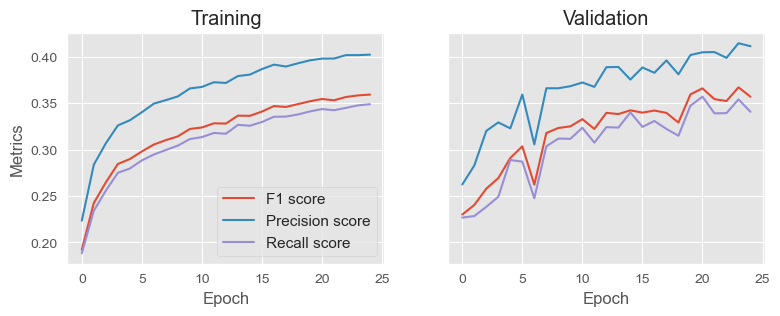

In [26]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (9,3), sharey=True)
ax1.plot(Train_results['training']['macro/f1'])
ax1.plot(Train_results['training']['macro/precision'])
ax1.plot(Train_results['training']['macro/recall'])
ax2.plot(Train_results['validating']['macro/f1'])
ax2.plot(Train_results['validating']['macro/precision'])
ax2.plot(Train_results['validating']['macro/recall'])
ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")
ax1.set_ylabel("Metrics")
ax1.set_title("Training")
ax2.set_title("Validation")
ax1.legend(['F1 score', 'Precision score', 'Recall score'], fontsize=11)
#plt.suptitle('Macro average metrics during training')
#plt.savefig(f"MetricsEvol_SingleModelTraining_{batch_size}batchsize_{str(learning_rate).replace('.','_')}lr_{criterion}_{str(optim).split()[0]}_optim_{date.today()}.png")
plt.show()

#### iv) Plot the hamming loss evolution

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.array(Train_results['training']['hamming_loss']), label='Training')
plt.plot(np.array(Train_results['validating']['hamming_loss']), label='Validation')
plt.legend()
plt.title('Average Hamming distance')
plt.xlabel("Epochs")
plt.ylabel("Hamming loss")
plt.show()

# 6) TESTING

## 6.A) Loading trained models (optional)

In [ ]:
load_model = False

model_path = "25 epochs multilabel model/model_multilabel_25epochs_0_01lr_weightedLoss_2023-01-13.pth"
if load_model:
    if device=="cpu":
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    else:
        model.load_state_dict(torch.load(model_path))
    print(f"Model loaded from: \n {model_path}")

## 6.B) Running the testing and computing metrics

In [ ]:
testing_result = testing_model(test_dataloader, model, device, tags)

In [ ]:
report = classification_report(y_true=testing_result['ground_truth'], y_pred=testing_result['predicted'], output_dict=True, target_names=tags, zero_division=0)

## 6.C) Visual presentation of the results

In [ ]:
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="PiYG")

In [ ]:
mean_predictions = np.stack(testing_result['class_predictions'], axis = 0).mean(axis=0)
plt.figure()
plt.bar(x = range(17), height=mean_predictions)
plt.xticks(range(17))
plt.title("Average accuracy of each class")
plt.show()